<a href="https://colab.research.google.com/github/prernac-dotcom/object_detection_yolo/blob/main/object_detection_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ultralytics opencv-python scikit-learn matplotlib scikit-image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving vecteezy_people-crossing-the-road-on-zebra-tallin_28257759.mp4 to vecteezy_people-crossing-the-road-on-zebra-tallin_28257759.mp4


In [3]:
import os
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)


Total frames read: 278

0: 384x640 10 persons, 1 traffic light, 1 stop sign, 165.3ms
Speed: 6.3ms preprocess, 165.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


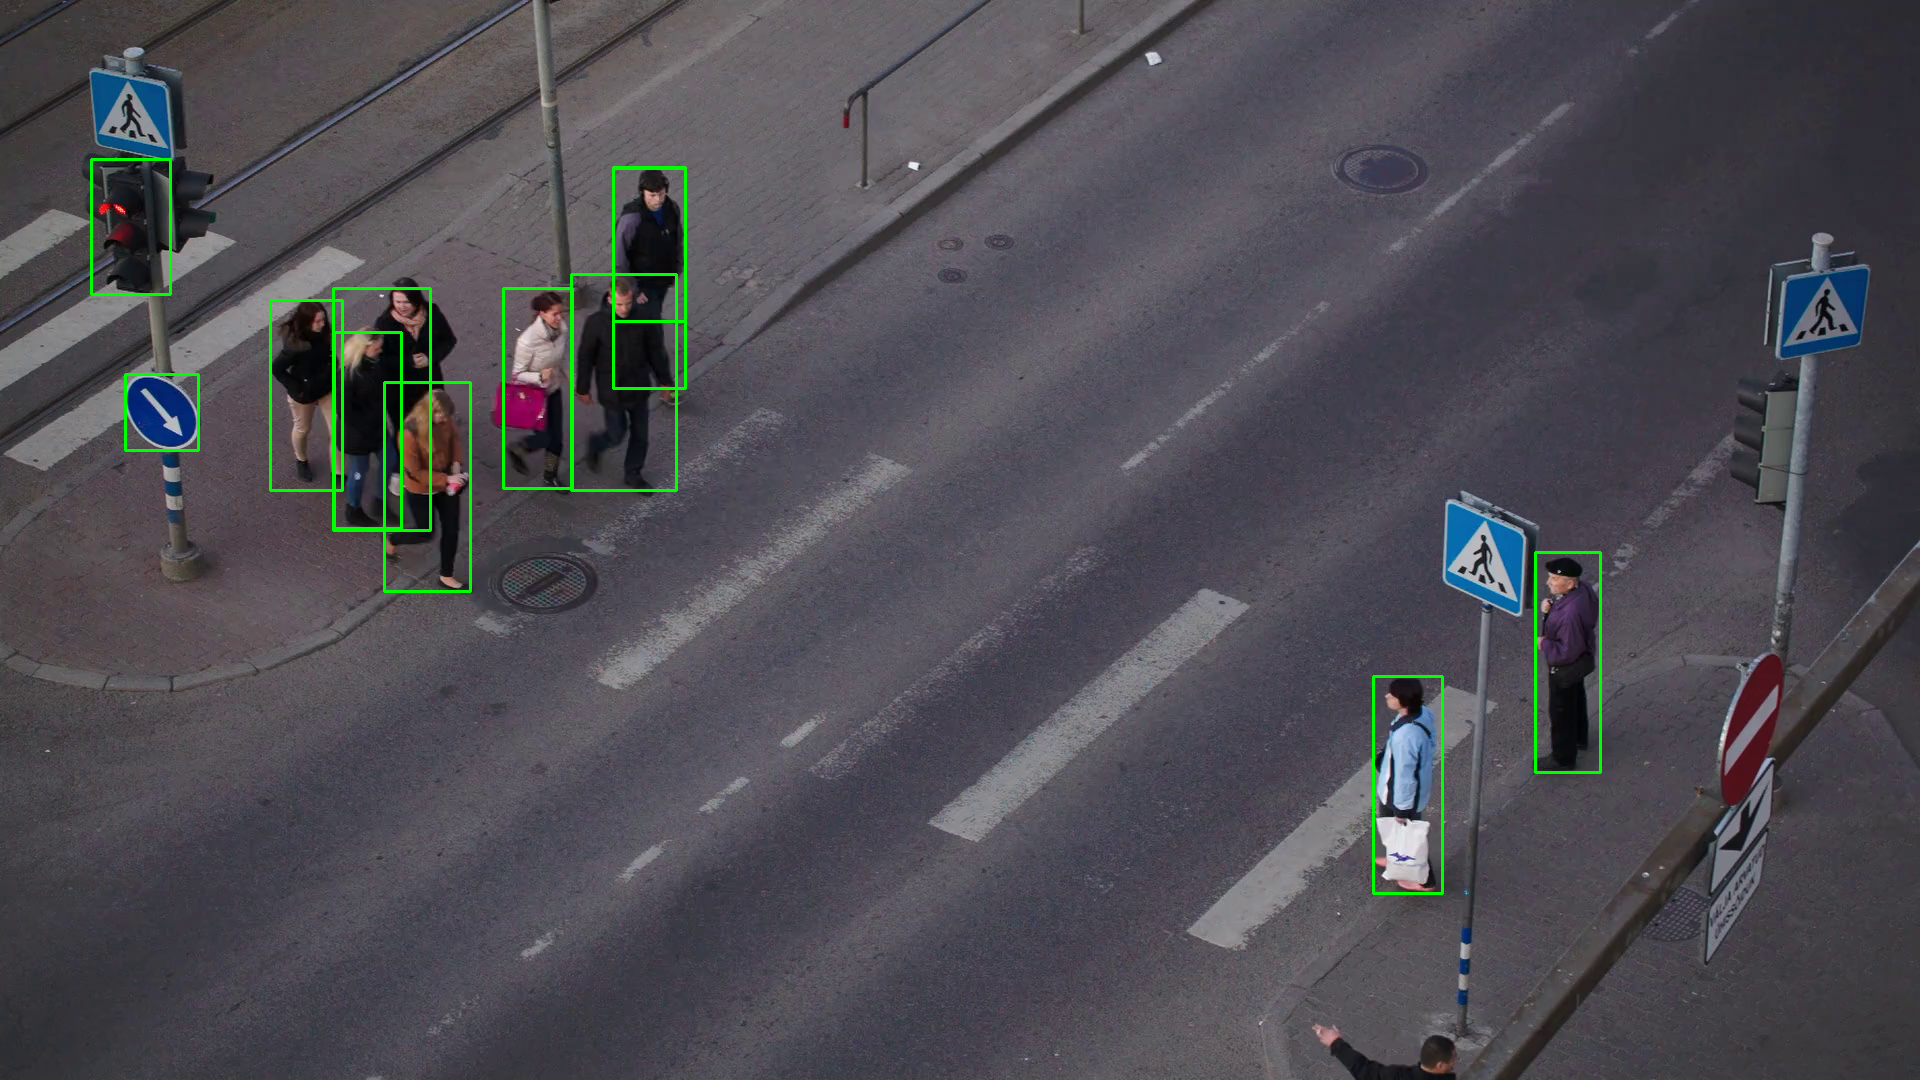

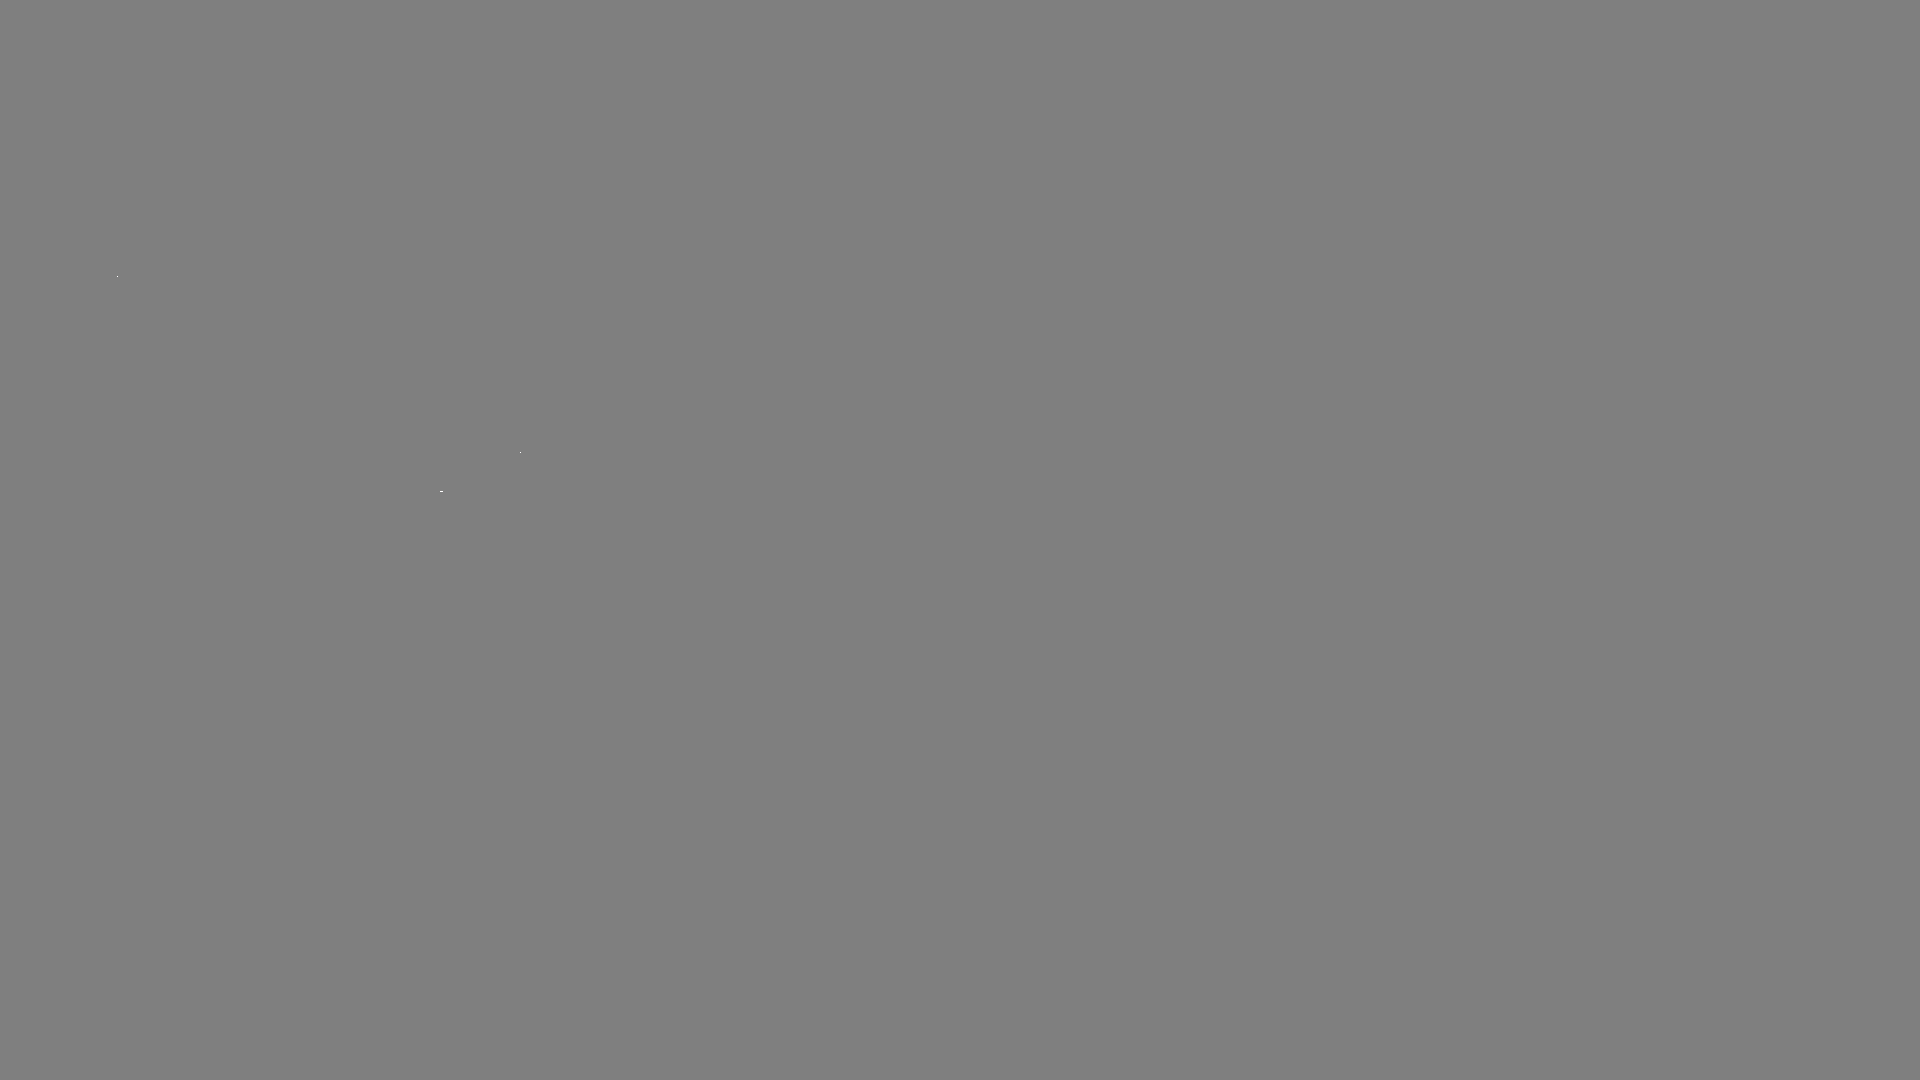

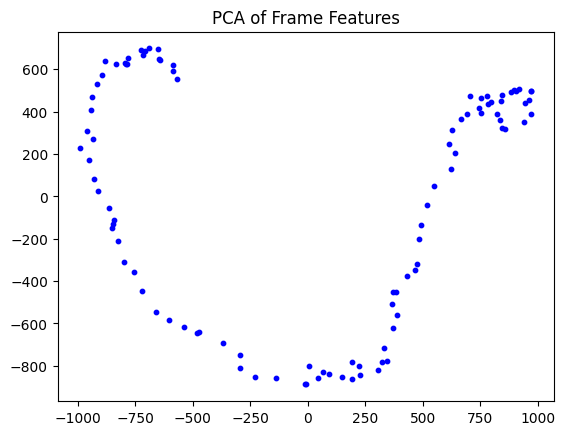

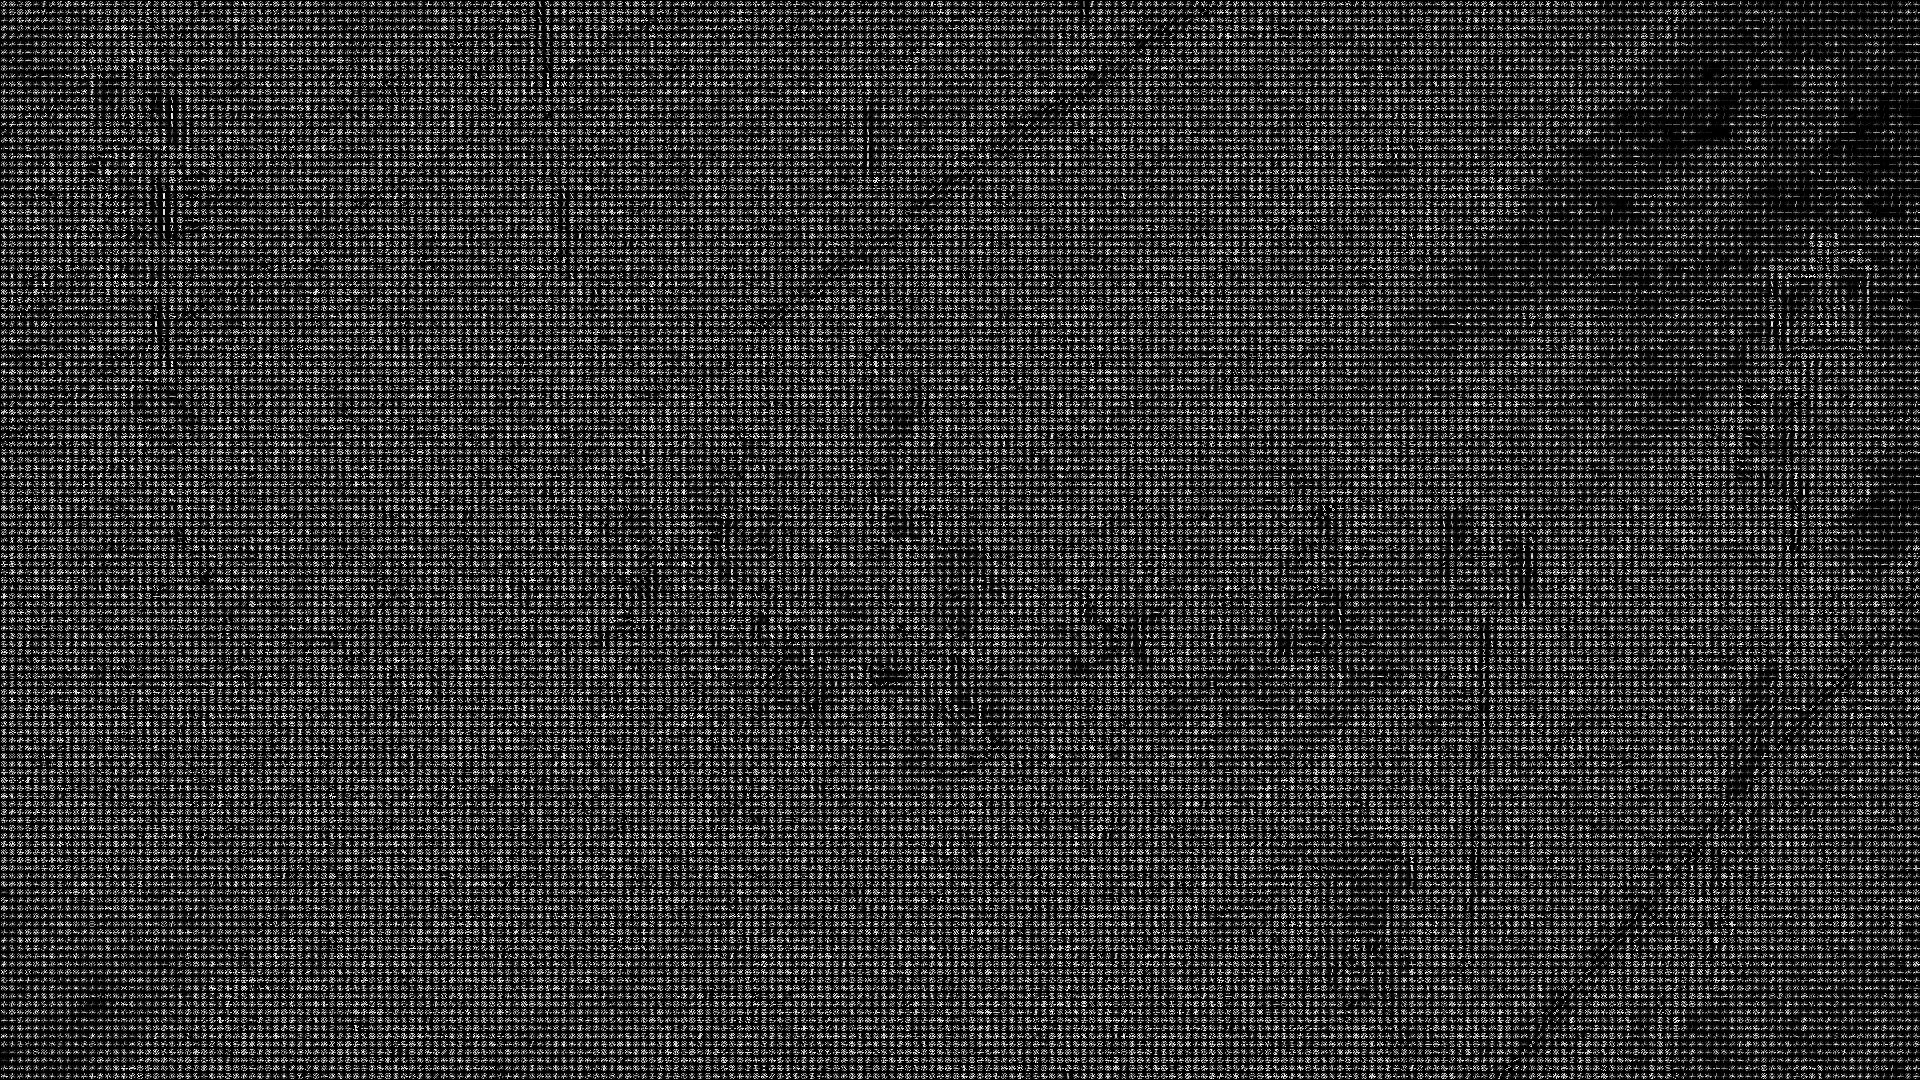

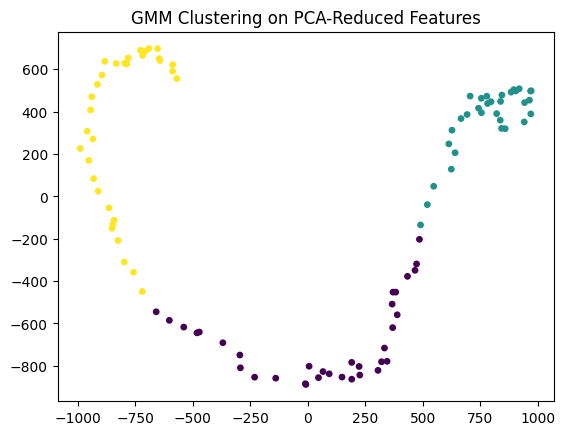

In [15]:
import cv2
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from skimage.feature import hog
from matplotlib import pyplot as plt
from IPython.display import display, Image
from google.colab.patches import cv2_imshow
from ultralytics import YOLO

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

# Load the video
video_path = "video.mp4"
cap = cv2.VideoCapture(video_path)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

print(f"Total frames read: {len(frames)}")

# Proceed if enough frames
if len(frames) > 50:
    # 1. YOLOv8 Human Detection
    model = YOLO("yolov8n.pt")
    yolo_output = frames[0].copy()
    results = model(yolo_output)
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(yolo_output, (x1, y1), (x2, y2), (0,255,0), 2)
    yolo_path = "outputs/yolo_output.png"
    cv2.imwrite(yolo_path, yolo_output)
    cv2_imshow(yolo_output)

    # 2. Background Subtraction
    fgbg = cv2.createBackgroundSubtractorMOG2()
    bg_output = fgbg.apply(frames[20])
    bg_path = "outputs/background_output.png"
    cv2.imwrite(bg_path, bg_output)
    cv2_imshow(bg_output)

    # 3. PCA on Frame Features
    flattened = [cv2.resize(f, (64, 64)).flatten() for f in frames[:100]]
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(flattened)
    plt.figure()
    plt.scatter(reduced[:,0], reduced[:,1], c='blue', s=10)
    plt.title("PCA of Frame Features")
    pca_path = "outputs/pca_plot.png"
    plt.savefig(pca_path)
    plt.show()

    # 4. HOG Features + Bounding Box
    hog_frame = cv2.cvtColor(frames[60], cv2.COLOR_BGR2GRAY)
    features, hog_image = hog(hog_frame, visualize=True)
    hog_image = (hog_image * 255).astype(np.uint8)
    hog_path = "outputs/hog_output.png"
    cv2.imwrite(hog_path, hog_image)
    cv2_imshow(hog_image)

    # 5. Gaussian Mixture Model Clustering on PCA Features
    gmm = GaussianMixture(n_components=3)
    labels = gmm.fit_predict(reduced)
    plt.figure()
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', s=15)
    plt.title("GMM Clustering on PCA-Reduced Features")
    gmm_path = "outputs/gmm_clusters.png"
    plt.savefig(gmm_path)
    plt.show()

else:
    print("Not enough frames read for full processing.")


In [16]:
from google.colab import files
for file in os.listdir("outputs"):
    files.download(f"outputs/{file}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>